# Tools scripts
The notebook must run in the same directory with "train", "test", "val_seen", "val_unseen", "envdrop" and "joint_train_envdrop". Please pay attention to the location where the script runs.

In [1]:
import copy
import gzip
import itertools
import json
import pickle
import random
import re
import threading
import time
from collections import Counter

import clip
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
from nltk.tokenize import PunktSentenceTokenizer
from numba import jit
from PIL import Image
from tqdm.notebook import tqdm

plt.rcParams['axes.unicode_minus'] = False
# nltk.download("punkt")
# nltk.download("averaged_perceptron_tagger")
# sns.set()
# plt.style.use('ggplot')

# Train tokenizer

In [51]:
# use R2R
# before running this cell, R2R instruction dataset must be downloaded into folder "r2r"
import pickle

from nltk.tokenize import PunktSentenceTokenizer

splits = ["train", "val_seen", "val_unseen", "test"]
all_text = ""
for split in splits:
    sub_data_path = "r2r/R2R_%s.json"%(split)
    with open(sub_data_path, "r") as f:
        sub_data = json.loads(f.read())
    for item in tqdm(sub_data):
        for i in range(3):
            all_text += item["instructions"][i]+" "
sent_tokenizer = PunktSentenceTokenizer(all_text.lower())
f = open('r2r_sent_tokenizer.pickle', 'wb')
pickle.dump(sent_tokenizer, f)
f.close()
f = open('r2r_sent_tokenizer.pickle', 'rb')
sent_tokenizer = pickle.load(f)
f.close()

  0%|          | 0/4675 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

  0%|          | 0/1391 [00:00<?, ?it/s]

In [ ]:
# use VLN-CE
import pickle

from nltk.tokenize import PunktSentenceTokenizer

splits = ["train", "val_seen", "val_unseen", "test"]
all_text = ""
for split in splits:
    sub_data_path = "%s/%s.json.gz"%(split,split)
    with gzip.open(sub_data_path, "r") as f:
        sub_data = json.loads(f.read())
    for item in tqdm(sub_data["episodes"]):
        all_text += item["instruction"]["instruction_text"]+" "
sent_tokenizer = PunktSentenceTokenizer(all_text)
f = open('r2r_sent_tokenizer.pickle', 'wb')
pickle.dump(sent_tokenizer, f)
f.close()
f = open('r2r_sent_tokenizer.pickle', 'rb')
sent_tokenizer = pickle.load(f)
f.close()

# FGR2R's chunking
https://github.com/YicongHong/Fine-Grained-R2R


In [31]:
import copy
import functools
import json
import re
import sys
from collections import Counter

import numpy as np
#!pip install stanza
import stanza

# stanza.download("en")


def print_progress(iteration, total, prefix='', suffix='', decimals=1, bar_length=100):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        bar_length  - Optional  : character length of bar (Int)
    """
    str_format = "{0:." + str(decimals) + "f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '_' * filled_length + '-' * (bar_length - filled_length)

    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

def check_lemma(word):
    """ Two special words, keep them in original form """
    if word.text in ['left','your']:
        return word.text
    else:
        return word.lemma

class Tokenizer(object):
    """ Class to tokenize and encode a sentence. """
    SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')  # Split on any non-alphanumeric character

    def __init__(self):
        pass

    def split_sentence(self, sentence):
        """ Break sentence into a list of words and punctuation """
        toks = []
        for word in [s.strip().lower() for s in self.SENTENCE_SPLIT_REGEX.split(sentence.strip()) if
                     len(s.strip()) > 0]:
            # Break up any words containing punctuation only, e.g. '!?', unless it is multiple full stops e.g. '..'
            if all(c in string.punctuation for c in word) and not all(c in '.' for c in word):
                toks += list(word)
            else:
                toks.append(word)
        return toks

def create_chunk(doc, nlp):
    doc = nlp(doc)
    
    max_kdx = len(doc.sentences) - 1
    instr_lemma = [['<start>']]
    for kdx, sent in enumerate(doc.sentences):

        root_sub = []; conj_sub = []
        for word in sent.words:
            if (word.deprel == 'root'):
                root_sub.append(int(word.id))
            elif (word.deprel == 'conj' and word.head == 1) or (word.deprel == 'conj' and (word.head in root_sub or word.head in conj_sub)):
                conj_sub.append(int(word.id))

        max_jdx = len(sent.words) - 1
        instr_lemma_sub = []; instr_depend_sub = []; instr_lemma_sub = []; ti = 0
        for jdx, word in enumerate(sent.words):
            if (word.deprel == 'root') and (('root' in instr_depend_sub) or ('parataxis' in instr_depend_sub)):
                # print('1', word.lemma, instr_depend_sub)
                if len(instr_lemma_sub) >= 2:
                    ''' check for the special cases of turning and the word "and","then" '''
                    if (('advmod' in instr_depend_sub) or ('xcomp' in instr_depend_sub)) and ('obj' not in instr_depend_sub) and ('obl' not in instr_depend_sub) and ('nmod' not in instr_depend_sub):
                        if (instr_lemma[-1][-1] == 'and') or (instr_lemma_sub[0]=='and') or (instr_lemma[-1][-1] == 'then') or (instr_lemma_sub[0]=='then'):
                            instr_lemma[-1] += instr_lemma_sub
                            instr_lemma_sub = []; instr_depend_sub = []
                        else:
                            'add to the next chunk'
                    else:
                        # print('a', instr_lemma_sub)
                        instr_lemma.append(instr_lemma_sub)
                        instr_lemma_sub = []; instr_depend_sub = []

            elif ti <= len(conj_sub)-1:
                if word.head == conj_sub[ti]:
                    ti += 1
                    # print('2', word.lemma, instr_depend_sub)
                    if len(instr_lemma_sub) >= 2:
                        ''' check for the special cases of turning and the word "and","then" '''
                        if (len(instr_lemma_sub) < 4) and (('advmod' in instr_depend_sub) or ('xcomp' in instr_depend_sub)) and ('obj' not in instr_depend_sub) and ('obl' not in instr_depend_sub) and ('nmod' not in instr_depend_sub):
                            if (instr_lemma[-1][-1] == 'and') or (instr_lemma_sub[0]=='and') or (instr_lemma[-1][-1] == 'then') or (instr_lemma_sub[0]=='then'):
                                instr_lemma[-1] += instr_lemma_sub
                                instr_lemma_sub = []; instr_depend_sub = []
                            else:
                                'add to the next chunk'
                        else:
                            # print('b', instr_lemma_sub)
                            instr_lemma.append(instr_lemma_sub)
                            instr_lemma_sub = []; instr_depend_sub = []

            elif (word.deprel == 'parataxis') and (('root' in instr_depend_sub) or ('parataxis' in instr_depend_sub)):
                if len(instr_lemma_sub) >= 2:
                    ''' check for the special cases of turning and the word "and","then" '''
                    if (('advmod' in instr_depend_sub) or ('xcomp' in instr_depend_sub)) and ('obj' not in instr_depend_sub) and ('obl' not in instr_depend_sub) and ('nmod' not in instr_depend_sub):
                        if (instr_lemma[-1][-1] == 'and') or (instr_lemma_sub[0]=='and') or (instr_lemma[-1][-1] == 'then') or (instr_lemma_sub[0]=='then'):
                            instr_lemma[-1] += instr_lemma_sub
                            instr_lemma_sub = []; instr_depend_sub = []
                        else:
                            'add to the next chunk'
                    else:
                        instr_lemma.append(instr_lemma_sub)
                        instr_lemma_sub = []; instr_depend_sub = []

            if word.deprel not in ['punct']:
                instr_lemma_sub.append(check_lemma(word))
                instr_depend_sub.append(word.deprel)

        if len(instr_lemma_sub) >= 2:
            instr_lemma.append(instr_lemma_sub)
        else:
            instr_lemma[-1] += instr_lemma_sub
    instr_lemma = [" ".join(v) for v in instr_lemma[1:]]
    return instr_lemma

# Segmentation Tool

In [2]:
def sub_segment_clip(train_data, append_dot=True, keep_subs=True, refine=False, segment_func=None, lower_all=False):
    """
    Params:
        train_data: a dataset dict
        append_dot: whether to add a "." at the end of sub-instructions
        keep_subs: whether to keep sub-instruction text after processing
        refine: whether to use proposed refine processing
        segment_func: the function used to segment instructions, default is `nltk.sent_tokenize`
        lower_all: whether to lower all characters in sub-instructions.
    Return:
        train_data with "sub_instruction_tokens" and "sub_instruction"
    """
    if segment_func is None:
        segment_func = nltk.sent_tokenize
    print(segment_func)
    return_data = copy.deepcopy(train_data)
    train_data = train_data["episodes"]
    # pre process
    char_pattern = re.compile(r"[a-zA-Z]")
    for i, item in enumerate(tqdm(train_data)):
        inst = item["instruction"]["instruction_text"]
        inst = inst.strip()
        start_idx = 0
        while not char_pattern.search(inst[start_idx]):
            start_idx += 1
        inst = inst[start_idx:]
        if lower_all:
            inst = inst.lower()
        train_data[i]["instruction"]["instruction_text"] = inst.replace("...", ".").replace("..", ".").replace(".",". ").replace("  ", " ")
    
    # sentence tokenize by nltk
    pattern = re.compile(r"\r\n")
    for i, item in enumerate(tqdm(train_data)):
        inst = item["instruction"]["instruction_text"]
        res = []
        now = pattern.split(inst)
        for v in now:
            res.extend(segment_func(v))
        train_data[i]["sub_instruction"] = [piece.strip() for piece in res if piece.strip()]
    # refine
    if refine:
        punctuation_list = [",", "."]
        char_pattern = re.compile(r"[a-zA-Z]+")
        def judge_verb(word):
            const_verbs = ["wait", "turn", "walk", "stop"]
            if "VB" in word[1]:
                return True
            if word[0] in const_verbs:
                return True
            return False
        for i, item in enumerate(tqdm(train_data)):
            new_sub = []
            for k, piece in enumerate(item["sub_instruction"]):
                word_list = nltk.pos_tag(nltk.word_tokenize(piece))
                tmp = ""
                for x, word in enumerate(word_list):
                    if (word[0].lower()=="and" or word[0]=="," or word[0].lower()=="then") and (x+1<len(word_list) and judge_verb(word_list[x+1])):
                        if tmp and char_pattern.search(tmp):
                            new_sub.append(tmp)
                        if word[0].lower()=="and" or word[0].lower()=="then":
                            tmp = word[0]
                        else:
                            tmp = ""
                            
                    elif (word[0]=="and" or word[0]==",") and (x+1<len(word_list) and word_list[x+1][0]=="then"):
                        if tmp:
                            new_sub.append(tmp)
                        if word[0].lower()=="and" or word[0].lower()=="then":
                            tmp = word[0]
                        else:
                            tmp = ""
                    else:
                        if not tmp or word[0] in punctuation_list:
                            tmp+=word[0]
                        else:
                            tmp+=(" "+word[0])
                if tmp:
                    new_sub.append(tmp)
            train_data[i]["sub_instruction"] = new_sub
    
    # post process and generate tokens
    char_pattern = re.compile(r"[a-zA-Z]")
    max_len = 0
    instruction_vocab = return_data["instruction_vocab"]
    unk_index = instruction_vocab["UNK_INDEX"]
    pad_index = instruction_vocab["PAD_INDEX"]
    pad_len = 100
    sub_pad_len = 77
    sub_num = 10
    useless_sub = [pad_index]*sub_pad_len
    sub_split_index = -1
    for i, item in enumerate(tqdm(train_data)):
        tokens_all = []
        tokens_split = []
        for k, piece in enumerate(item["sub_instruction"]):
            piece = piece.strip()
            assert piece
            idx = len(piece)-1
            while idx>=0 and piece[idx] in [".", ","]:
                idx -= 1
            if append_dot:
                piece = piece[0:(idx+1)]+"."
            else:
                piece = piece[0:(idx+1)]
            piece = piece.replace("``", "\"").replace("''", "\"")
            train_data[i]["sub_instruction"][k] = piece
            piece_tokens = clip.tokenize(piece, truncate=True).squeeze(0).tolist()
            tokens_split.append(piece_tokens)
        if len(tokens_split)>sub_num:
            tokens_split = tokens_split[0:sub_num]
        tokens_split.extend([useless_sub]*(sub_num-len(tokens_split)))
        
        train_data[i]["instruction"]["instruction_tokens"] = item["instruction"]["instruction_tokens"][0:pad_len]
        train_data[i]["sub_instruction_tokens"] = tokens_split
        if not keep_subs:
            del item["sub_instruction"]
    return_data["episodes"] = train_data
    return return_data

# Process all data

In [3]:
# NLTK + refine (FSASub)
splits = ["train", "test", "val_seen", "val_unseen", "envdrop",  "joint_train_envdrop"]
f = open('r2r_sent_tokenizer.pickle', 'rb')
sent_tokenizer = pickle.load(f)
f.close()
sent_token = sent_tokenizer.tokenize
tic = time.time()
for split in splits:
    raw_data_path = "%s/%s.json.gz"%(split, split)
    sub_data_path = "%s/%s_sub.json.gz"%(split, split)
    with gzip.open(raw_data_path, "r") as f:
        raw_data = json.loads(f.read())
    sub_data = sub_segment_clip(raw_data, refine=True, append_dot=False, segment_func=sent_token)
    with gzip.open(sub_data_path, "w") as f:
        f.write(json.dumps(sub_data).encode("utf-8"))
print(time.time()-tic)

<bound method PunktSentenceTokenizer.tokenize of <nltk.tokenize.punkt.PunktSentenceTokenizer object at 0x7f94d10d8d30>>


  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/10819 [00:00<?, ?it/s]

<bound method PunktSentenceTokenizer.tokenize of <nltk.tokenize.punkt.PunktSentenceTokenizer object at 0x7f94d10d8d30>>


  0%|          | 0/3408 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

<bound method PunktSentenceTokenizer.tokenize of <nltk.tokenize.punkt.PunktSentenceTokenizer object at 0x7f94d10d8d30>>


  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

<bound method PunktSentenceTokenizer.tokenize of <nltk.tokenize.punkt.PunktSentenceTokenizer object at 0x7f94d10d8d30>>


  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

<bound method PunktSentenceTokenizer.tokenize of <nltk.tokenize.punkt.PunktSentenceTokenizer object at 0x7f94d10d8d30>>


  0%|          | 0/157232 [00:00<?, ?it/s]

  0%|          | 0/157232 [00:00<?, ?it/s]

  0%|          | 0/157232 [00:00<?, ?it/s]

  0%|          | 0/157232 [00:00<?, ?it/s]

294.63329577445984


In [ ]:
# NLTK
# splits = ["train", "test", "val_seen", "val_unseen"]#, "envdrop", "joint_train_envdrop"]
# sent_token = nltk.sent_tokenize
# for split in splits:
#     raw_data_path = "%s/%s.json.gz"%(split, split)
#     sub_data_path = "%s/%s_sub.json.gz"%(split, split)
#     with gzip.open(raw_data_path, "r") as f:
#         raw_data = json.loads(f.read())
#     sub_data = sub_segment_clip(raw_data, refine=True, append_dot=False, segment_func=sent_token)
#     with gzip.open(sub_data_path, "w") as f:
#         f.write(json.dumps(sub_data).encode("utf-8"))

In [14]:
# NLTK default
# splits = ["train", "test", "val_seen", "val_unseen"]#, "envdrop", "joint_train_envdrop"]
# f = open('r2r_sent_tokenizer.pickle', 'rb')
# sent_tokenizer = pickle.load(f)
# f.close()
# sent_token = sent_tokenizer.tokenize
# for split in splits:
#     raw_data_path = "%s/%s.json.gz"%(split, split)
#     sub_data_path = "%s/%s_sub.json.gz"%(split, split)
#     with gzip.open(raw_data_path, "r") as f:
#         raw_data = json.loads(f.read())
#     sub_data = sub_segment_clip(raw_data, refine=False, append_dot=False, segment_func=sent_token)
#     with gzip.open(sub_data_path, "w") as f:
#         f.write(json.dumps(sub_data).encode("utf-8"))

  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

In [33]:
# FGR2R 
splits = ["train", "test", "val_seen", "val_unseen", "envdrop", "joint_train_envdrop"]
nlp = stanza.Pipeline()
sent_token = functools.partial(create_chunk, nlp=nlp)
for split in splits:
    raw_data_path = "%s/%s.json.gz"%(split, split)
    sub_data_path = "%s/%s_sub.json.gz"%(split, split)
    with gzip.open(raw_data_path, "r") as f:
        raw_data = json.loads(f.read())
    sub_data = sub_segment_clip(raw_data, refine=False, append_dot=False, segment_func=sent_token)
    with gzip.open(sub_data_path, "w") as f:
        f.write(json.dumps(sub_data).encode("utf-8"))

functools.partial(<function create_chunk at 0x7f1510c1e8c8>, nlp=<stanza.pipeline.core.Pipeline object at 0x7f13f2573f60>)


  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/10819 [00:00<?, ?it/s]

functools.partial(<function create_chunk at 0x7f1510c1e8c8>, nlp=<stanza.pipeline.core.Pipeline object at 0x7f13f2573f60>)


  0%|          | 0/3408 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

functools.partial(<function create_chunk at 0x7f1510c1e8c8>, nlp=<stanza.pipeline.core.Pipeline object at 0x7f13f2573f60>)


  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

functools.partial(<function create_chunk at 0x7f1510c1e8c8>, nlp=<stanza.pipeline.core.Pipeline object at 0x7f13f2573f60>)


  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

# Statics

In [4]:
raw_instructions = []
sub_instructions = []
splits = ["train", "val_seen", "val_unseen","test"]
for split in splits:
    sub_data_path = "%s/%s_sub.json.gz"%(split, split)
    with gzip.open(sub_data_path, "r") as f:
        sub_data = json.loads(f.read())
    for item in tqdm(sub_data["episodes"]):
        raw_instructions.append(item["instruction"]["instruction_text"])
    for item in tqdm(sub_data["episodes"]):
        sub_instructions.append(item["sub_instruction"])

  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

In [5]:
lens = [len(raw_instructions), sum([len(v) for v in sub_instructions])]
print(np.mean([len(v) for v in sub_instructions]))

4.20363334124911


In [6]:
raw_len_list = [len(nltk.word_tokenize(v)) for v in raw_instructions]
sub_len_list = [len(nltk.word_tokenize(v)) for v in list(itertools.chain.from_iterable(sub_instructions))]

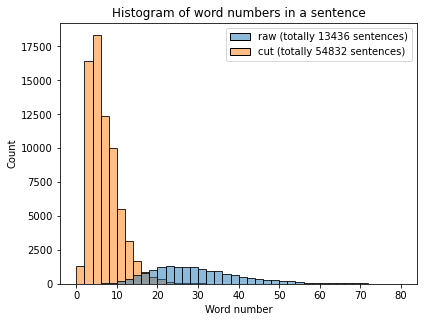

In [7]:
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_subplot()
sns.histplot({"raw (totally 13436 sentences)":raw_len_list,"segment (totally 54832 sentences)":sub_len_list}, ax=ax, binrange=[0,80], binwidth=2)
ax.set_xlabel("Word number")
ax.set_title("Histogram of word numbers in a sentence")
plt.savefig("tmp4.jpg",dpi=100, bbox_inches = 'tight')
plt.show()

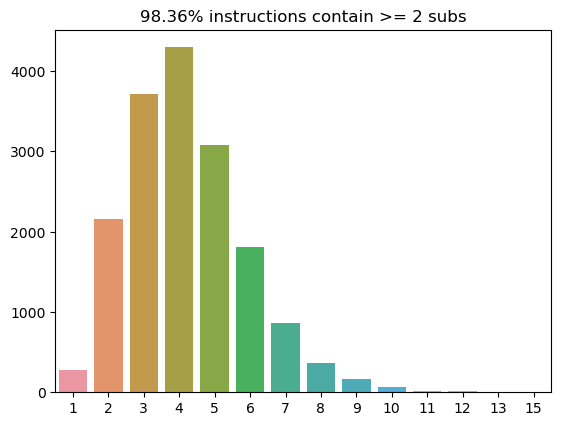

In [8]:
sub_num_list = [len(v) for v in sub_instructions]
sub_num_cnt = Counter(sub_num_list)
fig = plt.figure(figsize=(6.4,4.8),dpi=100)
ax = fig.add_subplot()
sns.barplot(x=list(sub_num_cnt.keys()), y=list(sub_num_cnt.values()))
plt.title("%2.2f%% instructions contain >= 2 subs"%((1-sub_num_cnt[1]/np.sum(list(sub_num_cnt.values())))*100 ))
plt.savefig("tmp3.jpg",dpi=100)

In [111]:
np.sum(list(sub_num_cnt.values()))

13436

# Example

In [57]:
split = "train"
sub_data_path = "%s/%s_sub.json.gz"%(split, split)
with gzip.open(sub_data_path, "r") as f:
    sub_data = json.loads(f.read())
split = "train"
sub_data_path = "/home/raven/codes/vln-ce/data/datasets/R2R_VLNCE_FGR2R/%s/%s_sub.json.gz"%(split, split)
with gzip.open(sub_data_path, "r") as f:
    sub_data1 = json.loads(f.read())

In [59]:
for i in range(0,10):
    print(sub_data["episodes"][i]["sub_instruction"])
    print(sub_data1["episodes"][i]["sub_instruction"])

['Go around the right side of the center unit', 'and stop by the right side doorway with the dining table and mirror in it']
['go around the right side of the center unit', 'and stop by the right side doorway with the dining table', 'and mirror in it']
['Go around the kitchen island', 'and wait between the tall cabinet and wine fridge']
['go around the kitchen island', 'and wait between the tall cabinet and wine fridge']
['Turn to the right', 'go past the refrigerator', 'Turn left', "and walk to the point where you 're to the hallway by the entry and dining room area"]
['turn to the right', 'go past the refrigerator', 'turn left and walk to the point where you be to the hallway by the entry and dining room area']
['Enter the bedroom', 'and go around the bed', 'Go to the closet on the far wall on the left', 'Stop in the doorway']
['enter the bedroom', 'and go around the bed', 'go to the closet on the far wall on the left', 'stop in the doorway']
['Walk around the bed in the bedroom', 'W

In [60]:
print(sub_data["episodes"][2])

{'episode_id': 3, 'trajectory_id': 4, 'scene_id': 'mp3d/7y3sRwLe3Va/7y3sRwLe3Va.glb', 'start_position': [-16.267200469970703, 0.1518409252166748, 0.7207760214805603], 'start_rotation': [0, 0.0007963267107332633, 0, 0.9999996829318346], 'info': {'geodesic_distance': 6.425291538238525}, 'goals': [{'position': [-12.337400436401367, 0.1518409252166748, 4.213699817657471], 'radius': 3.0}], 'instruction': {'instruction_text': "Turn to the right, go past the refrigerator.  Turn left and walk to the point where you're to the hallway by the entry and dining room area. ", 'instruction_tokens': [2300, 2246, 2202, 1819, 982, 1589, 2202, 1799, 9, 2300, 1251, 103, 2384, 2246, 2202, 1691, 2431, 2496, 4, 1773, 2246, 2202, 1036, 372, 2202, 800, 103, 660, 1842, 133, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'reference_path': [[-16.26720

# Comparison betweeen FGR2R and FSASub

In [1]:

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gzip
import json

plt.rcParams['font.sans-serif'] = ["Arial"]
plt.rcParams['axes.unicode_minus'] = False
sub_instructions = []
splits = ["train", "val_seen", "val_unseen","test"]
for split in splits:
    # /home/raven/codes/vln-ce/data/datasets/R2R_VLNCE_FGR2R/
    sub_data_path = "FSASub/%s/%s_sub.json.gz"%(split, split)
    with gzip.open(sub_data_path, "r") as f:
        sub_data = json.loads(f.read())
    for item in tqdm(sub_data["episodes"]):
        sub_instructions.append(item["sub_instruction"])
ssa_lens = [len(v) for v in sub_instructions]
sub_instructions = []
for split in splits:
    # /home/raven/codes/vln-ce/data/datasets/R2R_VLNCE_FGR2R/
    sub_data_path = "FGSub/%s/%s_sub.json.gz"%(split, split)
    with gzip.open(sub_data_path, "r") as f:
        sub_data = json.loads(f.read())
    for item in tqdm(sub_data["episodes"]):
        sub_instructions.append(item["sub_instruction"])
fgr2r_lens = [len(v) for v in sub_instructions]
fgr2r_mean = np.mean(np.array(fgr2r_lens))
ssa_mean = np.mean(np.array(ssa_lens))

  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

  0%|          | 0/10819 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/3408 [00:00<?, ?it/s]

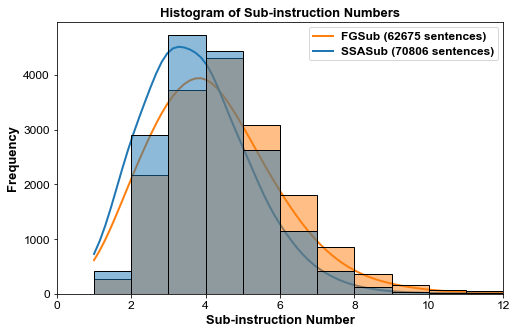

In [3]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
c = [plt.cm.Spectral(i/1.0) for i in range(2)]
sns.histplot({"FGSub (62675 sentences)": fgr2r_lens, "FSASub (70806 sentences)": ssa_lens}, ax=ax, binrange=[
             0, 12], binwidth=1, kde=True, kde_kws={"gridsize": 100, "bw_method": 0.4}, line_kws={"linewidth":2}, zorder=1000)
# ax.hist(fgr2r_lens,density=True, bins=10, alpha=0.75)
# ax.hist(ssa_lens,density=True, bins=10, alpha=0.75)
ax.set_xlabel("Sub-instruction Number", fontsize=13, fontweight='bold')
ax.set_ylabel("Frequency", fontsize=13, fontweight='bold')
ax.set_title("Histogram of Sub-instruction Numbers", fontsize=13, fontweight='bold')
ax.set_xlim([0, 12])
ax.legend(["FGSub (62675 sentences)", "FSASub (70806 sentences)"])
plt.xticks(fontsize=12, )
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
plt.savefig("cmp_sub.pdf", bbox_inches='tight')
plt.show()

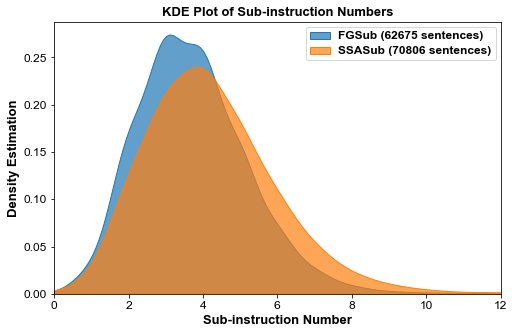

In [2]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
sns.kdeplot(fgr2r_lens, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.35)
sns.kdeplot(ssa_lens, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.35)
ax.set_xlabel("Sub-instruction Number", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Sub-instruction Numbers", fontsize=13, fontweight='bold')
ax.set_xlim([0, 12])
ax.legend(["FGSub (62675 sentences)", "FSASub (70806 sentences)"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')
plt.show()